In [1]:
import os
import glob
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import pickle

In [2]:
# =========================================================
# 1. LOAD DATASET
# =========================================================
def load_palm_vein_dataset(
    data_root="../Multispectral Palmprint Database/NIR",
    img_size=(256, 256),
    num_persons=30
):
    X, y, label_names = [], [], []

    all_dirs = sorted(
        d for d in os.listdir(data_root)
        if os.path.isdir(os.path.join(data_root, d))
    )
    person_dirs = all_dirs[:num_persons]
    print(f"Using persons: {person_dirs}")

    for label_idx, person in enumerate(person_dirs):
        label_names.append(person)
        folder = os.path.join(data_root, person)

        img_paths = []
        for ext in ("*.bmp", "*.png", "*.jpg", "*.jpeg", "*.tif", "*.tiff"):
            img_paths.extend(glob.glob(os.path.join(folder, ext)))

        if not img_paths:
            print(f"Warning: no images found in {folder}")
            continue

        for path in img_paths:
            img = Image.open(path).convert("L").resize(img_size)
            arr = np.array(img, dtype=np.float32) / 255.0
            X.append(arr.flatten())
            y.append(label_idx)

    X = np.stack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)
    return X, y, label_names


# =========================================================
# 2. SPLIT (TRAIN / VER / TEST)
# =========================================================
IMG_SIZE = (256, 256)
X, y, label_names = load_palm_vein_dataset(
    data_root="../Multispectral Palmprint Database/NIR",
    img_size=IMG_SIZE,
    num_persons=30
)
num_classes = len(label_names)
print("X:", X.shape, "y:", y.shape, "#classes:", num_classes)

# 20% test
X_trainval_raw, X_test_raw, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 10% ver overall => ver fraction within trainval = 0.10 / 0.80 = 0.125
X_train_raw, X_ver_raw, y_train, y_ver = train_test_split(
    X_trainval_raw, y_trainval,
    test_size=0.125,
    stratify=y_trainval,
    random_state=42
)

print("Train:", len(X_train_raw), "Ver:", len(X_ver_raw), "Test:", len(X_test_raw))


# =========================================================
# 3. STANDARDIZE + PCA (FIT ON TRAIN ONLY)
# =========================================================
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train_raw)
X_ver_s   = scaler.transform(X_ver_raw)
X_test_s  = scaler.transform(X_test_raw)

N_COMPONENTS = 150
pca = PCA(n_components=N_COMPONENTS, whiten=True, random_state=42)
X_train_pca = pca.fit_transform(X_train_s)
X_ver_pca   = pca.transform(X_ver_s)
X_test_pca  = pca.transform(X_test_s)

print("Train PCA:", X_train_pca.shape, "Ver PCA:", X_ver_pca.shape, "Test PCA:", X_test_pca.shape)


Using persons: ['0001', '0002', '0003', '0004', '0005', '0006', '0007', '0008', '0009', '0010', '0011', '0012', '0013', '0014', '0015', '0016', '0017', '0018', '0019', '0020', '0021', '0022', '0023', '0024', '0025', '0026', '0027', '0028', '0029', '0030']
X: (360, 65536) y: (360,) #classes: 30
Train: 252 Ver: 36 Test: 72
Train PCA: (252, 150) Ver PCA: (36, 150) Test PCA: (72, 150)


Model: "mlp_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        19,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │         1,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,694 (131.62 KB)

 Trainable params: 33,694 (131.62 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
8/8 - 2s - 215ms/step - accuracy: 0.0754 - loss: 3.4529 - val_accuracy: 0.0000e+00 - val_loss: 3.3639
Epoch 2/50
8/8 - 0s - 16ms/step - accuracy: 0.1944 - loss: 3.1781 - val_accuracy: 0.1667 - val_loss: 3.2697
Epoch 3/50
8/8 - 0s - 17ms/step - accuracy: 0.2937 - loss: 2.9831 - val_accuracy: 0.2222 - val_loss: 3.1698
Epoch 4/50
8/8 - 0s - 16ms/step - accuracy: 0.4484 - loss: 2.7696 - val_accuracy: 0.2778 - val_loss: 3.0458
Epoch 5/50
8/8 - 0s - 15ms/step - accuracy: 0.5595 - loss: 2.5222 - val_accuracy: 0.4167 - val_loss: 2.8735
Epoch 6/50
8/8 - 0s - 17ms/step - accuracy: 0.6865 - loss: 2.2319 - val_accuracy: 0.4722 - val_loss: 2.6567
Epoch 7/50
8/8 - 0s - 21ms/step - accuracy: 0.8214 - loss: 1.9038 - val_accuracy: 0.6667 - val_loss: 2.3900
Epoch 8/50
8/8 - 0s - 16ms/step - accuracy: 0.9008 - loss: 1.5220 - val_accuracy: 0.7222 - val_loss: 2.0663
Epoch 9/50
8/8 - 0s - 14ms/step - accuracy: 0.9325 - loss: 1.1470 - val_accuracy: 0.7500 - val_loss: 1.7211
Epoch 10/50
8/8 - 0s - 

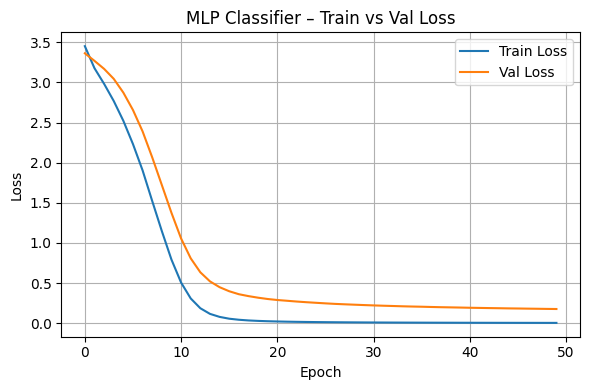

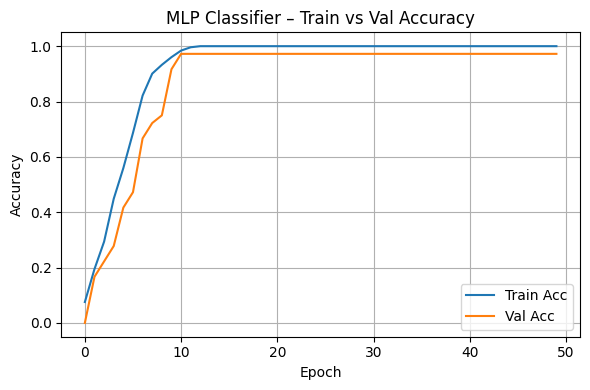


MLP+PCA Identification Accuracy (TEST): 0.9861
              precision    recall  f1-score   support

        0001       1.00      1.00      1.00         2
        0002       1.00      1.00      1.00         2
        0003       1.00      1.00      1.00         2
        0004       1.00      1.00      1.00         3
        0005       1.00      1.00      1.00         2
        0006       1.00      1.00      1.00         2
        0007       1.00      1.00      1.00         3
        0008       1.00      1.00      1.00         3
        0009       1.00      1.00      1.00         2
        0010       1.00      1.00      1.00         2
        0011       1.00      1.00      1.00         3
        0012       1.00      1.00      1.00         2
        0013       1.00      1.00      1.00         2
        0014       1.00      1.00      1.00         2
        0015       1.00      1.00      1.00         3
        0016       1.00      1.00      1.00         2
        0017       1.00      1.00

<Figure size 700x700 with 0 Axes>

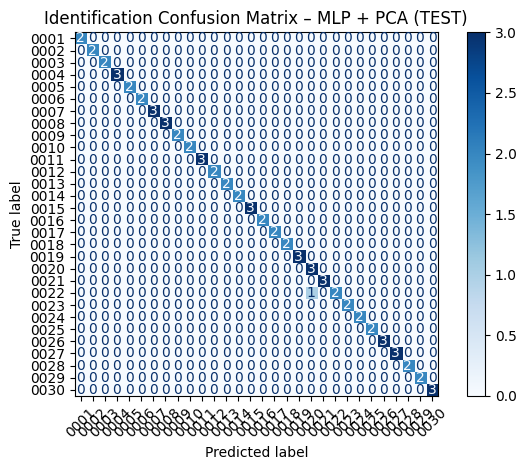

In [3]:
# =========================================================
# 4. TRAIN NORMAL MULTI-CLASS MLP (IDENTIFICATION TRAINING)
# =========================================================
def build_mlp_classifier(input_dim, num_classes, emb_dim=64):
    """
    We will use the Dense(emb_dim) layer as embedding for cosine verification.
    """
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(128, activation="relu")(inp)
    emb = layers.Dense(emb_dim, activation="relu", name="embedding")(x)
    x = layers.Dense(64, activation="relu")(emb)
    out = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inp, out, name="mlp_classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

mlp = build_mlp_classifier(N_COMPONENTS, num_classes, emb_dim=64)
mlp.summary()

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = mlp.fit(
    X_train_pca, y_train,
    validation_data=(X_ver_pca, y_ver),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Plot train vs val loss
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MLP Classifier – Train vs Val Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot train vs val accuracy
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("MLP Classifier – Train vs Val Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# =========================================================
# 5. IDENTIFICATION EVALUATION (TEST)
# =========================================================
y_test_pred = np.argmax(mlp.predict(X_test_pca, verbose=0), axis=1)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"\nMLP+PCA Identification Accuracy (TEST): {test_acc:.4f}")
print(classification_report(y_test, y_test_pred, target_names=label_names))

cm_id = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(7,7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_id, display_labels=label_names)
disp.plot(cmap="Blues", xticks_rotation=45, values_format="d")
plt.title("Identification Confusion Matrix – MLP + PCA (TEST)")
plt.tight_layout()
plt.show()


Best cosine threshold (VER): 0.8081
Verification trial accuracy (VER): 0.9861


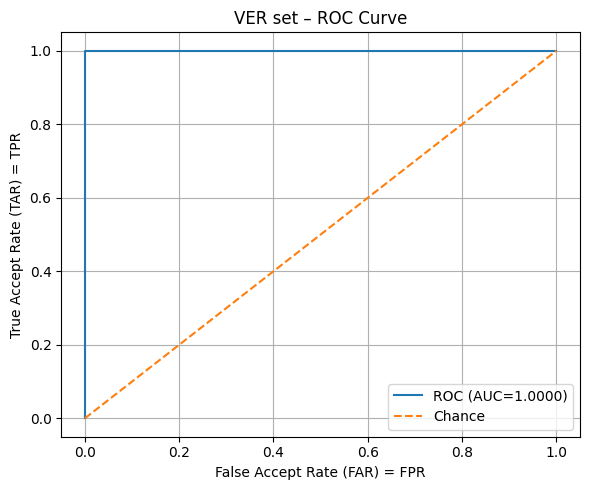

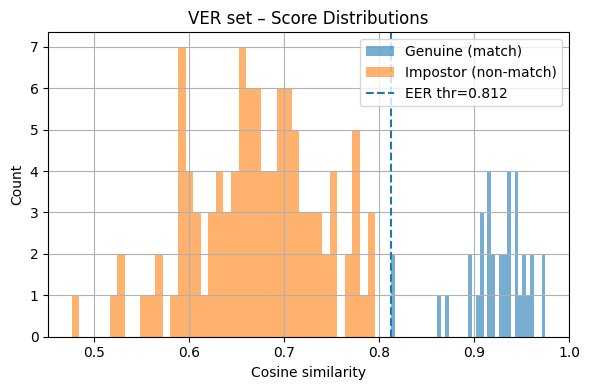

VER: AUC=1.0000, EER=0.0000, EER_threshold=0.8124


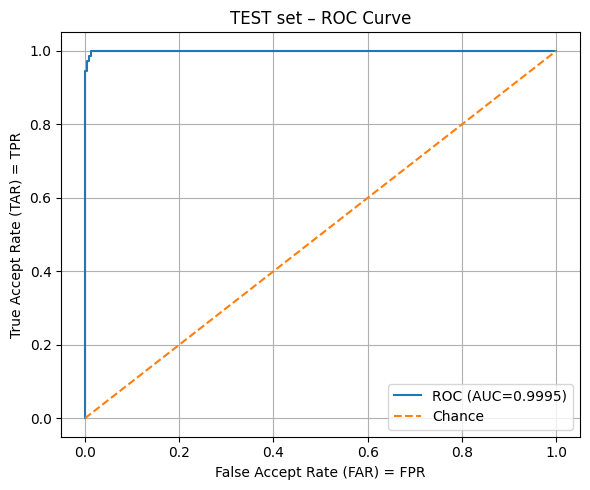

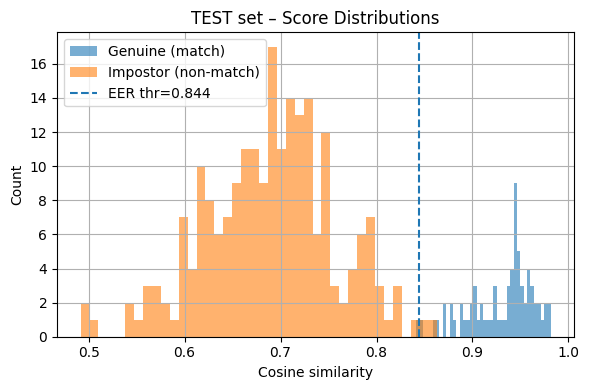

TEST: AUC=0.9995, EER=0.0139, EER_threshold=0.8444


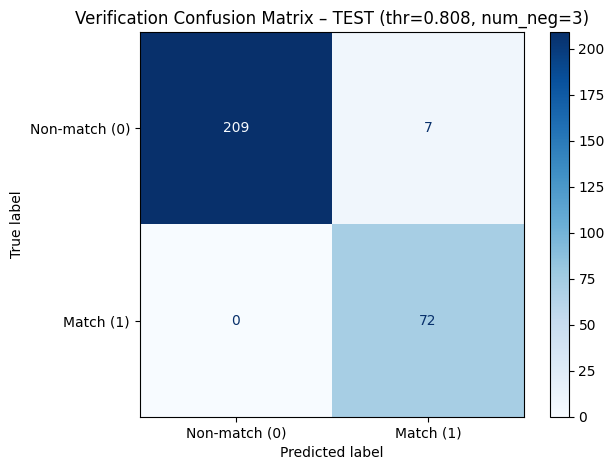

In [14]:
# =========================================================
# 6. BUILD EMBEDDING MODEL + TEMPLATES (COSINE VERIFICATION)
#    + L2 NORMALIZATION
# =========================================================
# embedding model: output the "embedding" layer
embedding_model = keras.Model(
    inputs=mlp.input,
    outputs=mlp.get_layer("embedding").output
)

def l2_normalize(x, axis=1, eps=1e-12):
    x = np.asarray(x, dtype=np.float32)
    norm = np.linalg.norm(x, axis=axis, keepdims=True)
    return x / (norm + eps)

def cosine_similarity(a, b, eps=1e-8):
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    return float(np.dot(a, b) / ((np.linalg.norm(a)+eps)*(np.linalg.norm(b)+eps)))

def build_templates(embeddings, labels, num_classes, normalize=True):
    """
    templates[c] = mean embedding of class c (optionally normalized at the end)
    embeddings are assumed already normalized if normalize=True.
    """
    templates = []
    for c in range(num_classes):
        idx = np.where(labels == c)[0]
        templates.append(embeddings[idx].mean(axis=0))
    templates = np.stack(templates).astype(np.float32)
    if normalize:
        templates = l2_normalize(templates, axis=1)
    return templates

# Compute embeddings
train_emb = embedding_model.predict(X_train_pca, verbose=0)
ver_emb   = embedding_model.predict(X_ver_pca, verbose=0)
test_emb  = embedding_model.predict(X_test_pca, verbose=0)

# L2 normalize embeddings (IMPORTANT for cosine threshold stability)
train_emb = l2_normalize(train_emb, axis=1)
ver_emb   = l2_normalize(ver_emb, axis=1)
test_emb  = l2_normalize(test_emb, axis=1)

# Build templates (mean then normalize)
templates = build_templates(train_emb, y_train, num_classes, normalize=True)


# =========================================================
# 7. TUNE SIMILARITY THRESHOLD ON VER SET (same impostor sampling)
# =========================================================
def tune_threshold(embeddings, labels, templates, num_neg=3, rng_seed=42):
    """
    num_neg = how many impostor (wrong-identity) comparisons per sample.
    """
    rng = np.random.default_rng(rng_seed)
    sims, gt = [], []
    C = len(templates)

    for i in range(len(embeddings)):
        true_c = int(labels[i])

        # positive trial
        sims.append(cosine_similarity(embeddings[i], templates[true_c]))
        gt.append(1)

        # negative trials
        for _ in range(num_neg):
            neg_c = int(rng.integers(0, C))
            while neg_c == true_c:
                neg_c = int(rng.integers(0, C))
            sims.append(cosine_similarity(embeddings[i], templates[neg_c]))
            gt.append(0)

    sims = np.array(sims, dtype=np.float32)
    gt = np.array(gt, dtype=np.int64)

    thresholds = np.linspace(-0.2, 0.99, 400)
    best_t, best_acc = None, -1.0

    for t in thresholds:
        pred = (sims >= t).astype(int)
        acc = float(np.mean(pred == gt))
        if acc > best_acc:
            best_acc = acc
            best_t = float(t)

    return best_t, best_acc, sims, gt

best_thr, ver_trial_acc, ver_sims, ver_gt = tune_threshold(ver_emb, y_ver, templates, num_neg=3)
print(f"\nBest cosine threshold (VER): {best_thr:.4f}")
print(f"Verification trial accuracy (VER): {ver_trial_acc:.4f}")


# =========================================================
# 8. VERIFICATION EVALUATION ON TEST SET
#    + ROC curve + AUC + EER + score distributions
#    (keeps same impostor trial generation: num_neg=3)
# =========================================================
from sklearn.metrics import roc_curve, roc_auc_score

def collect_trials(embeddings, labels, templates, num_neg=3, rng_seed=123):
    """
    Returns:
      sims: (N_trials,) cosine similarities
      gt  : (N_trials,) ground truth labels (1=genuine, 0=impostor)
    """
    rng = np.random.default_rng(rng_seed)
    C = len(templates)
    sims, gt = [], []

    for i in range(len(embeddings)):
        true_c = int(labels[i])

        # genuine (match)
        sims.append(cosine_similarity(embeddings[i], templates[true_c]))
        gt.append(1)

        # impostors (non-match)
        for _ in range(num_neg):
            neg_c = int(rng.integers(0, C))
            while neg_c == true_c:
                neg_c = int(rng.integers(0, C))
            sims.append(cosine_similarity(embeddings[i], templates[neg_c]))
            gt.append(0)

    return np.array(sims, dtype=np.float32), np.array(gt, dtype=np.int64)

def compute_eer(fpr, tpr, thresholds):
    """
    EER occurs when FPR == FNR (FNR = 1 - TPR).
    We find the point where |FPR - FNR| is minimal.
    Returns: eer, eer_threshold
    """
    fnr = 1.0 - tpr
    idx = np.nanargmin(np.abs(fpr - fnr))
    eer = float((fpr[idx] + fnr[idx]) / 2.0)
    eer_thr = float(thresholds[idx])
    return eer, eer_thr

def plot_roc_and_scores(sims, gt, title_prefix="Verification"):
    # ROC + AUC
    fpr, tpr, thr = roc_curve(gt, sims)  # treats higher score as more positive
    auc = float(roc_auc_score(gt, sims))
    eer, eer_thr = compute_eer(fpr, tpr, thr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC (AUC={auc:.4f})")
    plt.plot([0,1], [0,1], linestyle="--", label="Chance")
    plt.xlabel("False Accept Rate (FAR) = FPR")
    plt.ylabel("True Accept Rate (TAR) = TPR")
    plt.title(f"{title_prefix} – ROC Curve")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Score histograms
    sims_g = sims[gt == 1]
    sims_i = sims[gt == 0]

    plt.figure(figsize=(6,4))
    plt.hist(sims_g, bins=40, alpha=0.6, label="Genuine (match)")
    plt.hist(sims_i, bins=40, alpha=0.6, label="Impostor (non-match)")
    plt.axvline(eer_thr, linestyle="--", label=f"EER thr={eer_thr:.3f}")
    plt.xlabel("Cosine similarity")
    plt.ylabel("Count")
    plt.title(f"{title_prefix} – Score Distributions")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return auc, eer, eer_thr

# --- VER plots (optional but recommended, since threshold tuned on VER) ---
ver_sims2, ver_gt2 = collect_trials(ver_emb, y_ver, templates, num_neg=3, rng_seed=123)
ver_auc, ver_eer, ver_eer_thr = plot_roc_and_scores(ver_sims2, ver_gt2, title_prefix="VER set")
print(f"VER: AUC={ver_auc:.4f}, EER={ver_eer:.4f}, EER_threshold={ver_eer_thr:.4f}")

# --- TEST plots ---
test_sims, test_gt = collect_trials(test_emb, y_test, templates, num_neg=3, rng_seed=123)
test_auc, test_eer, test_eer_thr = plot_roc_and_scores(test_sims, test_gt, title_prefix="TEST set")
print(f"TEST: AUC={test_auc:.4f}, EER={test_eer:.4f}, EER_threshold={test_eer_thr:.4f}")

# Confusion matrix at your tuned threshold (best_thr from VER tuning)
test_pred_at_best = (test_sims >= best_thr).astype(int)
cm_ver = confusion_matrix(test_gt, test_pred_at_best)
disp = ConfusionMatrixDisplay(cm_ver, display_labels=["Non-match (0)", "Match (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Verification Confusion Matrix – TEST (thr={best_thr:.3f}, num_neg=3)")
plt.tight_layout()
plt.show()

In [15]:
# =========================================================
# 9. SINGLE-IMAGE VERIFICATION (unchanged logic, but ensure normalization)
# =========================================================
def verify_image_mlp_pca_cosine(
    mlp_embedding_model,
    scaler,
    pca,
    templates,
    img_path,
    claimed_person_name,
    label_names,
    img_size=(256, 256),
    threshold=0.3
):
    """
    TRUE verification: 1 image + claimed identity -> cosine similarity -> True/False
    Embedding is L2-normalized before similarity.
    """
    if claimed_person_name not in label_names:
        raise ValueError(f"claimed_person_name '{claimed_person_name}' not in label_names")

    claimed_id = label_names.index(claimed_person_name)

    img = Image.open(img_path).convert("L").resize(img_size)
    arr = np.array(img, dtype=np.float32) / 255.0
    x_raw = arr.flatten().reshape(1, -1)

    x_scaled = scaler.transform(x_raw)
    x_pca = pca.transform(x_scaled)

    emb = mlp_embedding_model.predict(x_pca, verbose=0)[0]
    emb = l2_normalize(emb.reshape(1, -1), axis=1)[0]  # normalize
    sim = cosine_similarity(emb, templates[claimed_id])

    is_match = (sim >= threshold)
    return is_match, claimed_person_name, float(sim)

# Example usage:
test_img_path = "../Multispectral Palmprint Database/NIR/0003/2_05.jpg"
is_match, claimed, sim = verify_image_mlp_pca_cosine(
    mlp_embedding_model=embedding_model,
    scaler=scaler,
    pca=pca,
    templates=templates,
    img_path=test_img_path,
    claimed_person_name="0003",
    label_names=label_names,
    img_size=IMG_SIZE,
    threshold=best_thr
)

print("\nSingle-image verification:")
print("Claimed:", claimed)
print("Cosine similarity:", sim)
print("Match:", is_match)



Single-image verification:
Claimed: 0003
Cosine similarity: 0.8694596290588379
Match: True


In [16]:
# =========================================================
# 10. SAVE
# =========================================================
embedding_model.save("mlp_embedding_model.h5")
mlp.save("mlp_classifier_model.h5")

with open("mlp_pca_cosine_verification_bundle.pkl", "wb") as f:
    pickle.dump({
        "scaler": scaler,
        "pca": pca,
        "label_names": label_names,
        "templates": templates,
        "best_threshold": best_thr
    }, f)

print("\nSaved: mlp_classifier_model.h5, mlp_embedding_model.h5, mlp_pca_cosine_verification_bundle.pkl")


Saved: mlp_classifier_model.h5, mlp_embedding_model.h5, mlp_pca_cosine_verification_bundle.pkl
